In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb


# Spectrum GCCs

## MP Pushforward

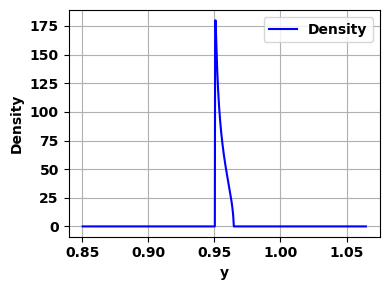

In [ ]:
def mp_support(q):
    """
    Return (lambda_minus, lambda_plus) for MP_q.
    """
    if q < 0:
        raise ValueError("q must be >= 0")
    s = np.sqrt(q)
    lam_minus = (1 - s) ** 2
    lam_plus  = (1 + s) ** 2
    return lam_minus, lam_plus

def mp_pdf(q, x):
    """
    Standard MP_q density at x (vectorized).
    For q > 0: f(x) = sqrt((λ+ - x)(x - λ-)) / (2π q x) on [λ-, λ+], else 0.
    For q = 0: degenerate at 1, density is 0 everywhere (handled outside).
    """
    x = np.asarray(x)
    if q == 0:
        return np.zeros_like(x, dtype=float)
    lam_minus, lam_plus = mp_support(q)
    out = np.zeros_like(x, dtype=float)
    mask = (x >= lam_minus) & (x <= lam_plus)
    xm = x[mask]
    # avoid division by 0 (MP_q has an integrable singularity at 0 only if q<1; formula ok for xm>0)
    denom = (2.0 * np.pi * q * np.maximum(xm, 1e-300))
    out[mask] = np.sqrt(np.maximum((lam_plus - xm) * (xm - lam_minus), 0.0)) / denom
    return out

def mp_pushforward_pdf(q, alpha, beta, y):
    """
    Density of Y = alpha * X + beta, where X ~ MP_q.
    Returns:
        pdf_y : array of density values at y (continuous part)
        atom_mass : float (mass of Dirac atom, if any; 0 otherwise)
        atom_loc  : float or None (location of atom)
        support_y : tuple (a,b) continuous-support interval for Y (sorted)
    Notes:
        - If q>1, MP_q has an atom at x=0 of mass 1 - 1/q; under push-forward this is at y=beta.
        - If q=0, distribution is Dirac at y=alpha+beta.
        - If alpha=0, push-forward collapses to Dirac at y=beta.
    """
    y = np.asarray(y, dtype=float)

    # Degenerate edge cases
    if alpha == 0:
        pdf = np.zeros_like(y)
        return pdf, 1.0, float(beta), (float(beta), float(beta))
    if q == 0:
        pdf = np.zeros_like(y)
        return pdf, 1.0, float(alpha + beta), (float(alpha + beta), float(alpha + beta))

    # Continuous part via change of variables: f_Y(y) = (1/|alpha|) f_X((y - beta)/alpha)
    x = (y - beta) / alpha
    pdf = (1.0 / abs(alpha)) * mp_pdf(q, x)

    # Continuous support interval
    lam_minus, lam_plus = mp_support(q)
    a, b = alpha * lam_minus + beta, alpha * lam_plus + beta
    support_y = (min(a, b), max(a, b))

    # Atom (if q>1) at y = beta with mass 1 - 1/q
    atom_mass = max(0.0, 1.0 - 1.0 / q) if q > 0 else 0.0
    atom_loc = float(beta) if atom_mass > 0 else None

    return pdf, atom_mass, atom_loc, support_y

# ---------------- Example usage ----------------
if __name__ == "__main__":
    q = 0.5
    alpha, beta = 0.005, 0.95

    # grid over y covering the continuous support
    lam_minus, lam_plus = mp_support(q)
    a, b = alpha * lam_minus + beta, alpha * lam_plus + beta
    y_grid = np.linspace(min(a, b) - 0.1, max(a, b) + 0.1, 2000)

    pdf_y, mass, loc, supp = mp_pushforward_pdf(q, alpha, beta, y_grid)
    # plot the density
    plt.figure(figsize=(4, 3))
    plt.plot(y_grid, pdf_y, label='Density', color='blue')
    if mass > 0 and loc is not None:
        plt.axvline(loc, color='red', linestyle='--', label=f'Atom at {loc:.3f} (mass {mass:.3f})')
    # plt.title(f'Push-forward of MP_{q} by Y={alpha}X+{beta}')
    plt.xlabel('y')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()



## GCC

In [ ]:
def phi_0(x):
    return np.sign(x)

In [4]:
def _pair_sign_matrix(x, y):
    """
        For two length-n vectors x,y, return the n×n symmetric matrix S with
        S[i,j] = sign((x[i]-x[j]) * (y[i]-y[j])) for i≠j, S[i,i]=0.
    """
    dx = x[:, None] - x[None, :]
    dy = y[:, None] - y[None, :]
    S = phi_0(dx * dy)
    np.fill_diagonal(S, 0.0)
    return S

def _cov_m2(x, y):
    """
        Exact φ-covariance for m=2:
        COV = average over i<j of sign((x_i - x_j)(y_i - y_j)).
        O(n^2) vectorized.
    """
    S = _pair_sign_matrix(x, y)
    iu = np.triu_indices_from(S, k=1)
    return S[iu].mean()

def _cov_m3(x, y):
    """
        Exact φ-covariance for m=3 using triangle identity:
        sum_{i<j<k} S_ij S_jk S_ki = (1/6) * trace(S^3).
        Then COV = [ (1/6) trace(S^3) ] / C(n,3).
    """
    S = _pair_sign_matrix(x, y)
    S3 = S @ S @ S
    tri_sum = np.trace(S3) / 6.0
    denom = comb(len(x), 3)
    return tri_sum / denom

def _cov_m_ge4_mc(x, y, m, samples=5000, rng=None):
    """
        Monte-Carlo φ-covariance for m>=4:
        COV ≈ average over random m-subsets of ∏_{i<j in subset} S_ij.
    """
#     n = len(x)
#     if rng is None:
#         rng = np.random.default_rng()
#     S = _pair_sign_matrix(x, y)
#     # Precompute upper-tri index mask for an m×m submatrix
#     vals = []
#     for _ in range(samples):
#         idx = rng.choice(n, size=m, replace=False)
#         sub = S[np.ix_(idx, idx)]
#         # product over i<j in the subset:
#         iu = np.triu_indices(m, k=1)
#         prod = np.prod(sub[iu])
#         vals.append(prod)
#     return float(np.mean(vals))
    pass

def phi_correlation_matrix(X, m, method="auto", mc_samples=5000, random_state=None):
    """
        Compute the p×p φ-correlation matrix for the antisymmetric kernel
            φ(x_{i_1},...,x_{i_m}) = ∏_{1≤k<l≤m} sign(x_{i_k} - x_{i_l})
        on columns of X (shape n×p).

        Parameters
        ----------
        X : array-like, shape (n, p)
            Data matrix: n samples of p-dimensional random vectors.
        m : int, m ≥ 2
            Order of the antisymmetric kernel.
        method : {"auto","exact","mc"}
            "auto": exact for m=2,3; MC for m≥4 or when exact is too big.
            "exact": force exact where implemented (m=2,3). Raises for m≥4.
            "mc": use Monte-Carlo for any m≥2.
        mc_samples : int
            Number of Monte-Carlo subsets per pair (used when method="mc" or m≥4 in "auto").
        random_state : int or np.random.Generator or None
            RNG seed or Generator for reproducibility.

        Returns
        -------
        C : ndarray, shape (p, p)
            φ-correlation matrix (for continuous data: equals φ-covariance).
            Diagonal entries are 1 (ties aside).
    """
    X = np.asarray(X, dtype=float)
    n, p = X.shape
    if m < 2:
        raise ValueError("m must be ≥ 2.")

    # Decide computation mode
    if method not in {"auto", "exact", "mc"}:
        raise ValueError("method must be 'auto', 'exact', or 'mc'.")

    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)

    C = np.empty((p, p), dtype=float)
    np.fill_diagonal(C, 1.0)  # for continuous data φ^2≡1 ⇒ variance=1

    # Heuristic threshold for exact enumeration size (only relevant for a future exact path m≥4)
    # Here we only implement exact for m=2,3; larger m falls back to MC.
    for a in range(p):
        xa = X[:, a]
        for b in range(a + 1, p):
            xb = X[:, b]

            cov = None
            if method == "mc":
                # Monte-Carlo for any m
                if m == 2:
                    cov = _cov_m2(xa, xb)
                elif m == 3:
                    cov = _cov_m3(xa, xb)
                else:
                    cov = _cov_m_ge4_mc(xa, xb, m, samples=mc_samples, rng=rng)
            elif method == "exact":
                if m == 2:
                    cov = _cov_m2(xa, xb)
                elif m == 3:
                    cov = _cov_m3(xa, xb)
                else:
                    raise NotImplementedError("Exact computation only implemented for m=2 and m=3.")
            else:  # auto
                if m == 2:
                    cov = _cov_m2(xa, xb)
                elif m == 3:
                    cov = _cov_m3(xa, xb)
                else:
                    cov = _cov_m_ge4_mc(xa, xb, m, samples=mc_samples, rng=rng)

            # For continuous data, COR = COV (since denom ≈ 1). If you want to handle ties,
            # estimate COVφ(xa,xa) and COVφ(xb,xb) similarly and divide.
            C[a, b] = C[b, a] = cov

    return C

## m = 2

In this case we know that $t=2/3$.

In [ ]:
# Environ 3 minutes
n, p, m = 500, 250, 2
X = np.random.randn(n, p)  # standardized Gaussian r.v.'s
C_phi_m_2 = phi_correlation_matrix(X, m=m, method="auto")

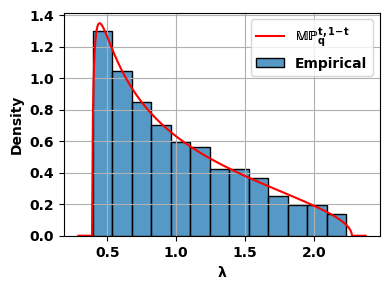

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
evals_m_2 = np.linalg.eigvalsh(C_phi_m_2)
sns.histplot(evals_m_2, bins=13, stat='density', label='Empirical')

# Theoretical MP density overlay
q = p / n
alpha, beta = 0.6666, 0.3333
# grid over y covering the continuous support
lam_minus, lam_plus = mp_support(q)
a, b = alpha * lam_minus + beta, alpha * lam_plus + beta
y_grid = np.linspace(min(a, b) - 0.1, max(a, b) + 0.1, 2000)
pdf_y, mass, loc, supp = mp_pushforward_pdf(q, alpha, beta, y_grid)
plt.plot(y_grid, pdf_y, label=r'$\mathbf{\mathbb{MP}^{t,1\!-\!t}_q}$', color='red')
if mass > 0 and loc is not None:
    plt.axvline(loc, color='red', linestyle='--', label=f'Atom at {loc:.3f} (mass {mass:.3f})')

plt.xlabel(r'$\mathbf{\lambda}$')
plt.ylabel('Density')
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("phi_corr_eigen_hist.pdf", bbox_inches='tight')  # uncomment to save

## m = 3

We start by estimating $t$.

In [5]:
import numpy as np

def estimate_alpha_beta_m3_sign_kernel(
    n_outer=20_000, n_inner=500, batch=2_000, seed=None
):
    rng = np.random.default_rng(seed)

    batch_means = []

    # ---- alpha ----
    remaining = n_outer
    while remaining > 0:
        bsz = min(batch, remaining)
        x = rng.standard_normal(bsz)
        z2 = rng.standard_normal((bsz, n_inner))
        z3 = rng.standard_normal((bsz, n_inner))
        s = phi_0((x[:, None] - z2) * (x[:, None] - z3) * (z2 - z3))
        bar_phi = s.mean(axis=1)
        batch_means.append(np.mean(bar_phi**2))
        remaining -= bsz

    alpha_hat = 2.0 * float(np.mean(batch_means))

    beta_hat = 1.0

    return alpha_hat, beta_hat

# -----------------------
# Example:
alpha, beta = estimate_alpha_beta_m3_sign_kernel(
    n_outer=100_000, n_inner=2000, batch=5000, seed=0
)
print(r"$\alpha=$", alpha)
print(r"$\beta=$", beta) 


$\alpha=$ 0.00099951748
$\beta=$ 1.0


We now compute the matrix.

In [10]:
# Example usage:
n, p, m = 1000, 500, 3
X = np.random.randn(n, p)  # standardized Gaussian r.v.'s
C_phi_m_3 = phi_correlation_matrix(X, m=m, method="auto")

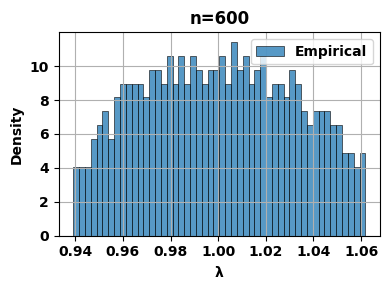

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
evals_m_3 = np.linalg.eigvalsh(C_phi_m_3)
sns.histplot(evals_m_3, bins=50, stat='density', label='Empirical')

# Theoretical MP density overlay
q = p / n
alpha, beta = alpha/beta, 1 - alpha/beta 
# grid over y covering the continuous support
lam_minus, lam_plus = mp_support(q)
a, b = alpha * lam_minus + beta, alpha * lam_plus + beta
y_grid = np.linspace(min(a, b) - 0.1, max(a, b) + 0.1, 2000)
pdf_y, mass, loc, supp = mp_pushforward_pdf(q, alpha, beta, y_grid)
# plt.plot(y_grid, pdf_y, label=r'$\mathbf{\mathbb{MP}^{t,1\!-\!t}_q}$', color='red')
if mass > 0 and loc is not None:
    plt.axvline(loc, color='red', linestyle='--', label=f'Atom at {loc:.3f} (mass {mass:.3f})')

plt.title('n=600')
plt.xlabel(r'$\mathbf{\lambda}$')
plt.ylabel('Density')
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig("phi_corr_eigen_hist.pdf", bbox_inches='tight')  # uncomment to save

# Test

In [1]:
import numpy as np
from time import perf_counter

def triple_sum_naive(S: np.ndarray) -> float:
    """
    Classic triple loop:
    sum_{i<j<k} s_{ij} * s_{jk} * s_{ik}
    """
    S = np.asarray(S)
    n = S.shape[0]
    assert S.shape == (n, n)
    total = 0.0
    for i in range(n-2):
        for j in range(i+1, n-1):
            sij = S[i, j]
            for k in range(j+1, n):
                total += sij * S[j, k] * S[i, k]
    return float(total)

def triple_sum_vectorized(S: np.ndarray) -> float:
    """
    Vectorized O(n^3) using BLAS:
    sum_k a^T (B a) with a = U[:k, k], B = U[:k, :k], U = triu(S, 1)
    """
    S = np.asarray(S)
    n = S.shape[0]
    assert S.shape == (n, n)
    U = np.triu(S, k=1)
    total = 0.0
    for k in range(2, n):
        a = U[:k, k]      # shape (k,)
        B = U[:k, :k]     # k x k, strictly upper-triangular
        total += a @ (B @ a)
    return float(total)

# ---------- quick test & (optional) timing ----------
if __name__ == "__main__":
    rng = np.random.default_rng(0)
    for n in [6, 10, 20, 40]:
        A = rng.standard_normal((n, n))
        S = A - A.T        # exact skew-symmetric, diag=0

        t0 = perf_counter()
        v_vec = triple_sum_vectorized(S)
        t1 = perf_counter()
        v_naive = triple_sum_naive(S)
        t2 = perf_counter()

        ok = np.allclose(v_vec, v_naive, rtol=1e-12, atol=1e-12)
        print(f"n={n:>2d}: equal={ok}  vec={v_vec:.12g}  naive={v_naive:.12g}  "
              f"(t_vec={t1-t0:.4f}s, t_naive={t2-t1:.4f}s)")


n= 6: equal=True  vec=-1.78849636617  naive=-1.78849636617  (t_vec=0.0001s, t_naive=0.0000s)
n=10: equal=True  vec=-6.53528663186  naive=-6.53528663186  (t_vec=0.0001s, t_naive=0.0001s)
n=20: equal=True  vec=57.1516360657  naive=57.1516360657  (t_vec=0.0001s, t_naive=0.0005s)
n=40: equal=True  vec=443.65143127  naive=443.65143127  (t_vec=0.0001s, t_naive=0.0038s)
